In [1]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Load training and test data
train_data = sio.loadmat('C:/Users/hc/Desktop/DSAI/Module Project/DATASET/SVHN/train_32x32.mat')
test_data = sio.loadmat('C:/Users/hc/Desktop/DSAI/Module Project/DATASET/SVHN/test_32x32.mat')

In [3]:
# Extract images and labels
X_train = train_data['X']
y_train = train_data['y'].flatten()
X_test = test_data['X']
y_test = test_data['y'].flatten()

In [4]:
# Fix the label issue
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [5]:
# Rearrange the data into (num_samples, height, width, channels)
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

In [6]:
#print(f"Reshaped Training data shape: {X_train.shape}")

In [7]:
# Data Preprocessing

# Normalize the images to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [8]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False
)

In [9]:
# Fit the generator to the training data
datagen.fit(X_train)

In [10]:
# Build the CNN Model
model = models.Sequential([
    # First Conv Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Second Conv Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # 10 classes for digits 0-9
])

In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 64)          0

In [12]:
# Train the Model


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [13]:
# Train the model using the augmented data from ImageDataGenerator
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/50
1145/1145 [==============================] - ETA: 0s - loss: 1.4270 - accuracy: 0.5223

C:\Users\hc\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1145/1145 [==============================] - 209s 179ms/step - loss: 1.4270 - accuracy: 0.5223 - val_loss: 0.6063 - val_accuracy: 0.8302
Epoch 2/50
1145/1145 [==============================] - 215s 188ms/step - loss: 0.9533 - accuracy: 0.6965 - val_loss: 0.4982 - val_accuracy: 0.8639
Epoch 3/50
1145/1145 [==============================] - 232s 202ms/step - loss: 0.8478 - accuracy: 0.7308 - val_loss: 0.4536 - val_accuracy: 0.8765
Epoch 4/50
1145/1145 [==============================] - 249s 217ms/step - loss: 0.7876 - accuracy: 0.7508 - val_loss: 0.4081 - val_accuracy: 0.8868
Epoch 5/50
1145/1145 [==============================] - 249s 218ms/step - loss: 0.7509 - accuracy: 0.7629 - val_loss: 0.3857 - val_accuracy: 0.8928
Epoch 6/50
1145/1145 [==============================] - 263s 229ms/step - loss: 0.7153 - accuracy: 0.7731 - val_loss: 0.3738 - val_accuracy: 0.8940
Epoch 7/50
1145/1145 [==============================] - 242s 211ms/step - loss: 0.6876 - accuracy: 0.7815 - val_loss: 0.343

In [14]:
# Evaluate the Model

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

In [16]:
# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

814/814 [==============================] - 10s 12ms/step - loss: 0.2522 - accuracy: 0.9332
Test accuracy: 93.32%


In [17]:
# Predict the labels for the test data
y_pred = np.argmax(best_model.predict(X_test), axis=-1)

814/814 [==============================] - 12s 14ms/step


In [18]:
# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1744
           1       0.95      0.96      0.95      5099
           2       0.95      0.95      0.95      4149
           3       0.91      0.92      0.91      2882
           4       0.94      0.96      0.95      2523
           5       0.93      0.93      0.93      2384
           6       0.91      0.92      0.92      1977
           7       0.95      0.92      0.93      2019
           8       0.93      0.85      0.89      1660
           9       0.90      0.90      0.90      1595

    accuracy                           0.93     26032
   macro avg       0.93      0.93      0.93     26032
weighted avg       0.93      0.93      0.93     26032



In [19]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

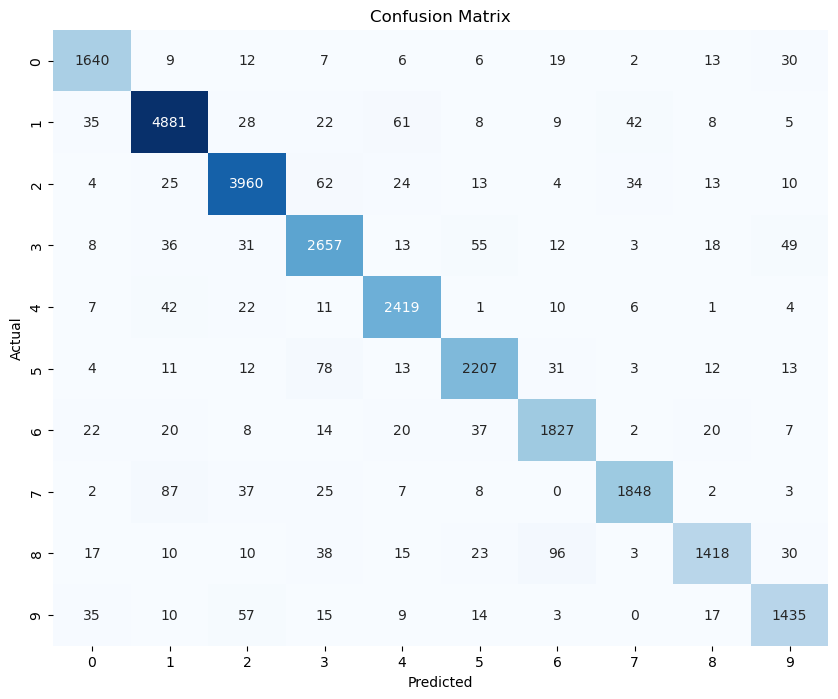

In [20]:
# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()